Task 1: Develop a Neural Network for Classification

Use TensorFlow or PyTorch to create a neural network for a classification task.
Train the model and evaluate its performance on a test set.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
torch.manual_seed(42)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std of MNIST
])

In [5]:
train_dataset =datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.86MB/s]


In [6]:
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class neuralnet(nn.Module):
    def __init__(self, hidden_size1=128, hidden_size2=64, dropout_rate=0.2):
        super(neuralnet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden_size1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 10)  # 10 output classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [14]:
model = neuralnet().to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_losses = []
train_accuracies = []

In [16]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')


Epoch [1/10], Loss: 0.3434, Accuracy: 89.68%
Epoch [2/10], Loss: 0.1669, Accuracy: 94.98%
Epoch [3/10], Loss: 0.1335, Accuracy: 96.00%
Epoch [4/10], Loss: 0.1133, Accuracy: 96.58%
Epoch [5/10], Loss: 0.1030, Accuracy: 96.81%
Epoch [6/10], Loss: 0.0924, Accuracy: 97.12%
Epoch [7/10], Loss: 0.0864, Accuracy: 97.35%
Epoch [8/10], Loss: 0.0786, Accuracy: 97.53%
Epoch [9/10], Loss: 0.0759, Accuracy: 97.65%
Epoch [10/10], Loss: 0.0703, Accuracy: 97.71%


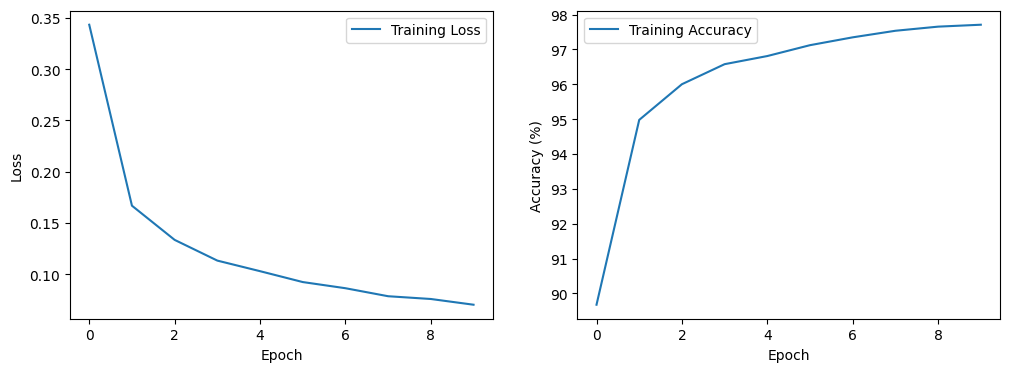

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [18]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        # Move data to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 97.91%


Task 2: Implement Hyperparameter Tuning

Use tools like GridSearchCV or RandomizedSearchCV to find the best hyperparameters for a model.
Evaluate the impact of different hyperparameters on model performance.

In [19]:
hyperparam_space = {
    'learning_rate': [0.001, 0.01, 0.1],
    'hidden_size1': [64, 128, 256],
    'hidden_size2': [32, 64, 128],
    'dropout_rate': [0.1, 0.3, 0.5],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'sgd']
}


In [20]:
def convert_to_python_types(config):
    return {
        'learning_rate': float(config['learning_rate']),
        'hidden_size1': int(config['hidden_size1']),
        'hidden_size2': int(config['hidden_size2']),
        'dropout_rate': float(config['dropout_rate']),
        'batch_size': int(config['batch_size']),
        'optimizer': str(config['optimizer'])
    }

In [23]:
def train_evaluate_model(config, train_dataset, test_dataset, num_epochs=5):
    # Convert numpy types to native Python types
    config = convert_to_python_types(config)

    # Create new data loaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    # Initialize model with current hyperparameters
    model = neuralnet(
        hidden_size1=config['hidden_size1'],
        hidden_size2=config['hidden_size2'],
        dropout_rate=config['dropout_rate']
    ).to(device)

    # Select optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

    criterion = nn.CrossEntropyLoss()

    # Training loop
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

    # Evaluate on test set
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy, np.mean(train_accuracies[-3:])  # Return test accuracy and avg of last 3 train accuracies

In [24]:
def random_search(search_space, train_dataset, test_dataset, num_iterations=10):
    results = []

    for i in range(num_iterations):
        print(f"\nIteration {i+1}/{num_iterations}")

        # Randomly sample hyperparameters
        config = {
            'learning_rate': np.random.choice(search_space['learning_rate']),
            'hidden_size1': np.random.choice(search_space['hidden_size1']),
            'hidden_size2': np.random.choice(search_space['hidden_size2']),
            'dropout_rate': np.random.choice(search_space['dropout_rate']),
            'batch_size': np.random.choice(search_space['batch_size']),
            'optimizer': np.random.choice(search_space['optimizer'])
        }

        print("Testing configuration:", config)

        # Train and evaluate
        test_acc, train_acc = train_evaluate_model(config, train_dataset, test_dataset)
        results.append({
            'config': config,
            'test_accuracy': test_acc,
            'train_accuracy': train_acc
        })

        print(f"Test Accuracy: {test_acc:.2f}% | Train Accuracy: {train_acc:.2f}%")

    return results

# Perform random search
search_results = random_search(hyperparam_space, train_dataset, test_dataset, num_iterations=10)



Iteration 1/10
Testing configuration: {'learning_rate': np.float64(0.01), 'hidden_size1': np.int64(64), 'hidden_size2': np.int64(128), 'dropout_rate': np.float64(0.5), 'batch_size': np.int64(64), 'optimizer': np.str_('sgd')}
Test Accuracy: 93.30% | Train Accuracy: 85.43%

Iteration 2/10
Testing configuration: {'learning_rate': np.float64(0.001), 'hidden_size1': np.int64(128), 'hidden_size2': np.int64(32), 'dropout_rate': np.float64(0.1), 'batch_size': np.int64(32), 'optimizer': np.str_('sgd')}
Test Accuracy: 89.62% | Train Accuracy: 83.50%

Iteration 3/10
Testing configuration: {'learning_rate': np.float64(0.001), 'hidden_size1': np.int64(64), 'hidden_size2': np.int64(32), 'dropout_rate': np.float64(0.5), 'batch_size': np.int64(64), 'optimizer': np.str_('adam')}
Test Accuracy: 94.27% | Train Accuracy: 86.24%

Iteration 4/10
Testing configuration: {'learning_rate': np.float64(0.01), 'hidden_size1': np.int64(128), 'hidden_size2': np.int64(128), 'dropout_rate': np.float64(0.5), 'batch_si

In [25]:
best_result = max(search_results, key=lambda x: x['test_accuracy'])
print("\n=== Best Configuration ===")
print("Hyperparameters:", best_result['config'])
print(f"Test Accuracy: {best_result['test_accuracy']:.2f}%")
print(f"Train Accuracy: {best_result['train_accuracy']:.2f}%")


=== Best Configuration ===
Hyperparameters: {'learning_rate': np.float64(0.001), 'hidden_size1': np.int64(128), 'hidden_size2': np.int64(32), 'dropout_rate': np.float64(0.1), 'batch_size': np.int64(64), 'optimizer': np.str_('adam')}
Test Accuracy: 97.84%
Train Accuracy: 97.02%


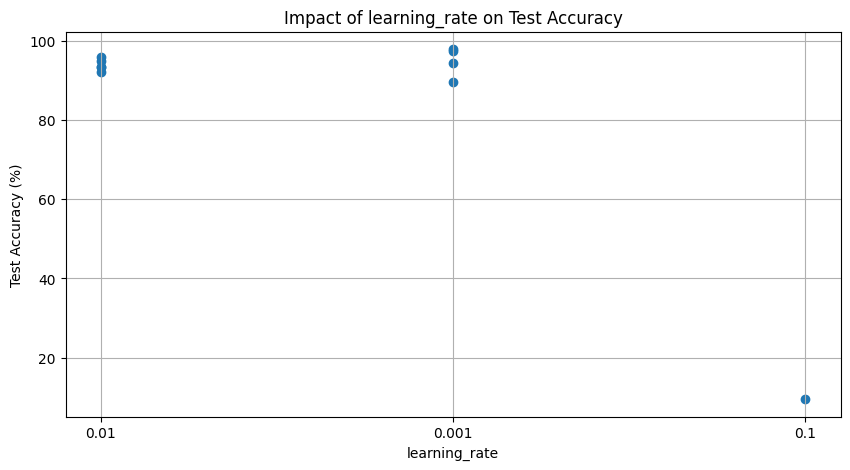

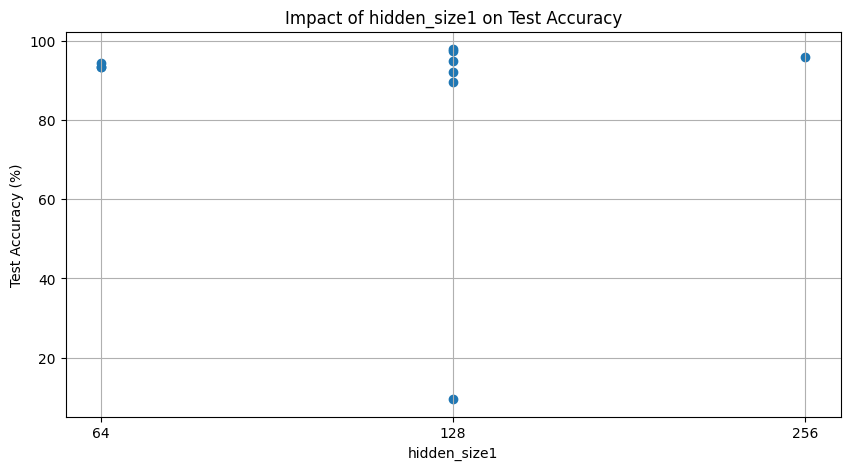

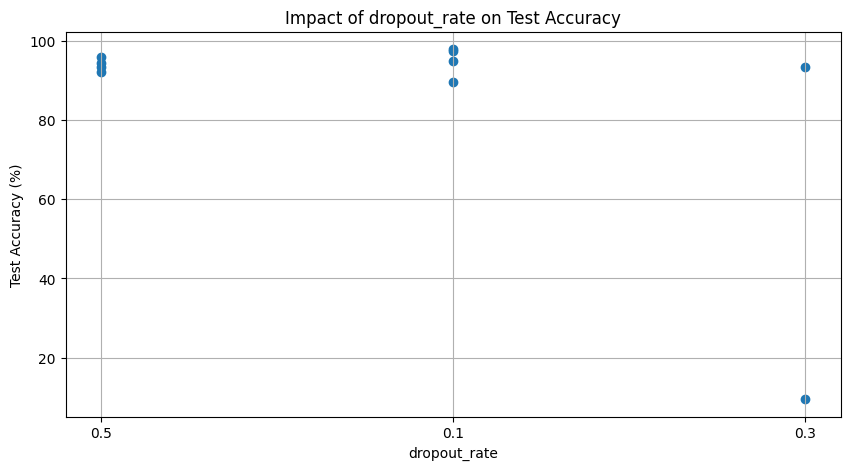

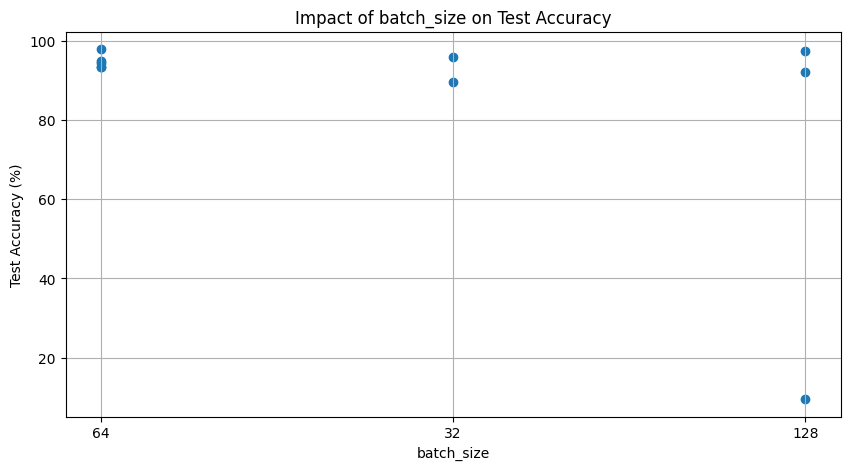

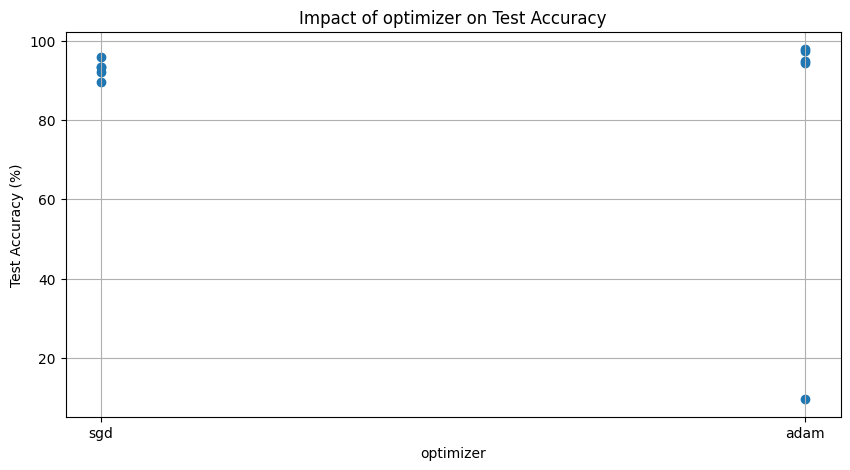

In [26]:
def plot_hyperparam_impact(results, param_name):
    param_values = [str(r['config'][param_name]) for r in results]
    accuracies = [r['test_accuracy'] for r in results]

    plt.figure(figsize=(10, 5))
    plt.scatter(param_values, accuracies)
    plt.title(f'Impact of {param_name} on Test Accuracy')
    plt.xlabel(param_name)
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    plt.show()

# Plot impact of different hyperparameters
plot_hyperparam_impact(search_results, 'learning_rate')
plot_hyperparam_impact(search_results, 'hidden_size1')
plot_hyperparam_impact(search_results, 'dropout_rate')
plot_hyperparam_impact(search_results, 'batch_size')
plot_hyperparam_impact(search_results, 'optimizer')

In [44]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00


In [41]:
pip install python-multipart

In [46]:
%%writefile main.py
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import io
import logging


Writing main.py


In [47]:
app = FastAPI()

In [48]:
# Save the trained model
torch.save(model.state_dict(), 'mnist_model.pth')
print("Model saved as mnist_model.pth")

Model saved as mnist_model.pth


In [49]:
model = neuralnet()
model.load_state_dict(torch.load('mnist_model.pth', map_location=torch.device('cpu')))
model.eval()


neuralnet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [50]:
@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    image = Image.open(io.BytesIO(await file.read())).convert('L').resize((28, 28))
    image_array = (np.array(image) / 255.0 - 0.1307) / 0.3081
    tensor = torch.FloatTensor(image_array).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        prediction = model(tensor).argmax().item()
    return {"prediction": prediction}

@app.get("/")
def home():
    return {"message": "MNIST Classifier"}

In [51]:
%%writefile requirements.txt
fastapi==0.95.2
uvicorn==0.22.0
python-multipart==0.0.6
torch==2.0.1
pillow==9.5.0
numpy==1.24.3


Writing requirements.txt


In [52]:
%%writefile Dockerfile
FROM python:3.9-slim
WORKDIR /app
COPY . .
RUN pip install --no-cache-dir -r requirements.txt
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8080"]

Writing Dockerfile


In [53]:
from google.colab import files
!zip -r deployment_files.zip main.py requirements.txt Dockerfile mnist_model.pth
files.download('deployment_files.zip')

  adding: main.py (deflated 38%)
  adding: requirements.txt (deflated 12%)
  adding: Dockerfile (deflated 14%)
  adding: mnist_model.pth (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>